# Compare results from Galaxy Builder to Hart (2017)

Ross Hart fit a relationship between GZ2 debiased morpholocal votes and the length-weighted, dominant chirality only pitch angle reported by [SpArcFiRe](http://sparcfire.ics.uci.edu/). In this notebook we compare the length-weighted galaxy builder pitch angles to that relationship.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from IPython.display import display
from gzbuilderspirals.oo import *
import lib.galaxy_utilities as gu
from lib.custom_progressbar import Progress
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.simplefilter('ignore', category=UserWarning)

Load in a list of available subject ids and the [GZ2 debiased vote counts](https://data.galaxyzoo.org/).

In [3]:
sid_list = pd.read_csv('lib/subject-id-list.csv').values[:, 0]
df_gz2 = pd.read_csv('lib/gz2_hart16.csv').set_index('dr7objid')

Define some helper functions for feature extraction

In [4]:
def get_nsaid(sid):
    return np.int64(gu.meta_map.get(sid, {}).get('NSA id', np.nan))

def get_dr7objid(sid):
    return np.int64(gu.meta_map.get(sid, {}).get('SDSS dr7 id', np.nan))

def hart_wavg(gal):
    return (np.hstack((
        gal['t10_arms_winding_a28_tight_debiased'],
        gal['t10_arms_winding_a29_medium_debiased'],
        gal['t10_arms_winding_a30_loose_debiased'],
    )) * (np.arange(3) + 1)).sum()

def hart_mavg(gal):
    return (np.hstack((
        gal['t11_arms_number_a31_1_debiased'],
        gal['t11_arms_number_a32_2_debiased'],
        gal['t11_arms_number_a33_3_debiased'],
        gal['t11_arms_number_a34_4_debiased'],
        gal['t11_arms_number_a36_more_than_4_debiased'],
    )) * (np.arange(5) + 1)).sum()


def hart_pa(wavg, mavg):
  return 6.37 * wavg + 1.30 * mavg + 4.34

def get_hart_params(row):
    gal = df_gz2.query('dr7objid == {dr7objid}'.format(**row.to_dict())).iloc[0]
    wavg, mavg = hart_wavg(gal), hart_mavg(gal)
    if wavg == 0.0 or mavg == 0.0:
        return np.nan, wavg, mavg
    return hart_pa(wavg, mavg), wavg, mavg

Generate a DataFrame containing GZB pitch angles, NSA IDs, SDSS DR7 IDs, and use it to calculate Hart (2017) pitch angles from the GZ2 data export. Then add a column with the pitch angle difference and an error approximation.

In [5]:
pas = []
p = Progress(min_value=0, max_value=len(sid_list))
for i, sid in enumerate(sid_list):
    p.update(i)
    arms = [
        Arm.load(os.path.join('lib/spiral_arms', f))
        for f in os.listdir('lib/spiral_arms')
        if str(sid) in f
    ]
    if len(arms) == 0:
        pas.append((np.nan, np.nan))
    else:
        pas.append(arms[0].get_parent().get_pitch_angle(arms))
p.update(i + 1, text='Done!')
pa_df = pd.DataFrame(pas, columns=('pa', 'sigma_pa'), index=sid_list).dropna();

In [6]:
pa_df['NSAID'] = pa_df.index.to_series().apply(get_nsaid)
pa_df['dr7objid'] = pa_df.index.to_series().apply(get_dr7objid)

hart_df = pa_df.apply(get_hart_params, axis=1, result_type='expand').rename(columns={0: 'hart_pa', 1: 'wavg', 2:'mavg'})
pa_df = pd.concat((pa_df, hart_df), axis=1)

pa_df['pa_diff'] = pa_df['pa'] - pa_df['hart_pa']
pa_df['pa_diff_err'] = np.sqrt(pa_df['sigma_pa']**2 + 7**2)

What do the distributions of pitch angles look like? Can the difference between the two be put down to error?

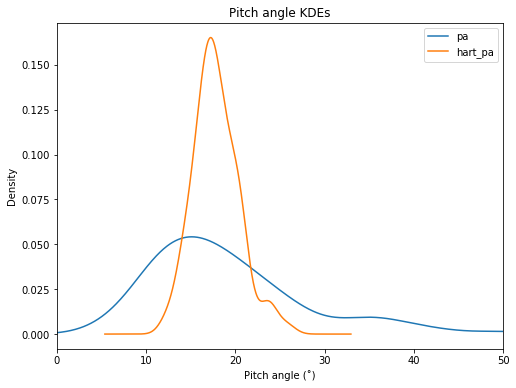

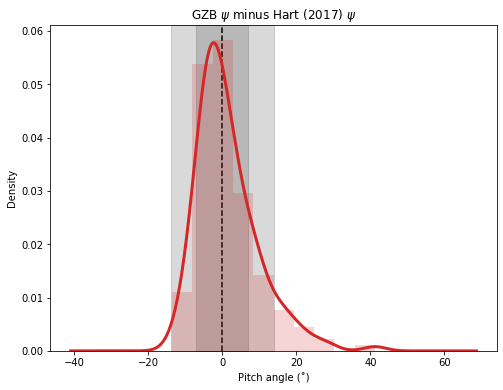

In [10]:
plt.figure(figsize=(8, 6))
pa_df[['pa', 'hart_pa']].plot.kde(ax=plt.gca())
plt.xlim(0, 50)
plt.title('Pitch angle KDEs')
plt.xlabel('Pitch angle (˚)')

plt.figure(figsize=(8, 6))
plt.title('GZB $\psi$ minus Hart (2017) $\psi$')
pa_df['pa_diff'].plot.hist(density=True, alpha=0.2, zorder=10, color='C3')
pa_df['pa_diff'].plot.kde(lw=3, zorder=10, c='C3')
ylims = plt.gca().get_ylim()
plt.fill_betweenx(np.linspace(0, ylims[1]), -7, 7, color='k', alpha=0.15, zorder=1)
plt.fill_betweenx(np.linspace(0, ylims[1]), -14, 14, color='k', alpha=0.15, zorder=1)
plt.vlines(0, *ylims, linestyles='dashed')
plt.ylim(*ylims)
plt.xlabel('Pitch angle (˚)')
plt.savefig('method-paper-plots/gzb-hart-comparison.pdf', bbox_inches='tight');